In [1]:
import tensorflow as tf
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) # set figure size for plotting in seaborn

In [2]:
def data_generator():
    while True:
        
        # draw 6 numbers from standard normal distribution
        
        datum = np.random.randn(6)       
        
        # define an offset
        offset = 0.3
        
        noise = np.random.randn() * 0.05
        
        target = np.sum(datum ** 2 ) + offset + noise
        
        # get the input, output pair as tf tensors
        yield (tf.constant(datum, dtype=tf.float32), tf.constant(target, dtype=tf.float32))

In [4]:
# sample an (input, output) pair from the generator
next(data_generator())

(<tf.Tensor: shape=(6,), dtype=float32, numpy=
 array([-1.2396818 , -0.01164282,  0.9739222 ,  0.5935517 ,  0.18968397,
         0.06239698], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.146094>)

In [5]:
# define a model in tensorflow

class tf_model(tf.keras.Model):
    def __init__(self):
        super(tf_model, self).__init__()
        
        # define model variable (offset)
        
        initializer = tf.keras.initializers.RandomNormal(mean=1)
        variable_shape = [1]
        
        self.model_variable = tf.Variable(initializer(variable_shape),
                                          dtype=tf.float32)
          
        # define model loss metric to keep track of the loss
        
        self.loss_metric = tf.keras.metrics.Mean()
        
    @tf.function
    def __call__(self, x):
        
        # function to fit
        output = tf.reduce_sum(x ** 2  , axis = 1) + self.model_variable
        
        return output


In [6]:
# set training hyperparameters

batch_size = 128
lr = 0.0005
n_epochs = 100
examples_per_epoch = 50

# instantiate model from the above defined model class
model = tf_model()
print(f"The initial parameter value is: {model.trainable_variables[0].numpy()[0]} \n")

# instantiate optimizer (stochastic gradient descent)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# initialize list of mean loss per epoch for later plotting
epoch_losses = []

The initial parameter value is: 1.0448782444000244 



In [7]:
# create a tensorflow Dataset object from the generator

dataset = tf.data.Dataset.from_generator(
     data_generator,
     output_signature=(
         tf.TensorSpec(shape=(6,), dtype=tf.float32),
         tf.TensorSpec(shape=(), dtype=tf.float32)))


# get batches of this dataset object

dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [8]:
for epoch in range(n_epochs):

    # iterate over 100 randomly generated training examples
    for x_batch, target_batch in dataset.take(examples_per_epoch):

        # calculate model output and loss within the gradient tape
        with tf.GradientTape() as tape:
            prediction_batch = model(x_batch)
            
            loss = tf.keras.losses.MSE(target_batch, prediction_batch)

        # obtain gradients tracked by the gradient tape with respect to the model parameters
        gradients = tape.gradient(loss, model.trainable_variables)

        # apply the gradients to the model parameters using the optimizer
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update loss metric for later inspection

        model.loss_metric.update_state(loss)
    if not (epoch % 10):
        print(f"The loss after epoch {epoch} is {model.loss_metric.result().numpy()} \n")
    
    epoch_losses.append(model.loss_metric.result().numpy())
    
    model.loss_metric.reset_states()
    
print(f"The final parameter estimate is: {model.trainable_variables[0].numpy()[0]}")

2021-10-31 14:16:39.057121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


The loss after epoch 0 is 0.5292680263519287 

The loss after epoch 10 is 0.1977306306362152 

The loss after epoch 20 is 0.07430343329906464 

The loss after epoch 30 is 0.028753209859132767 

The loss after epoch 40 is 0.012391347438097 

The loss after epoch 50 is 0.006024924106895924 

The loss after epoch 60 is 0.003746760543435812 

The loss after epoch 70 is 0.0030010207556188107 

The loss after epoch 80 is 0.0027103424072265625 

The loss after epoch 90 is 0.0025075883604586124 

The final parameter estimate is: 0.3051777482032776


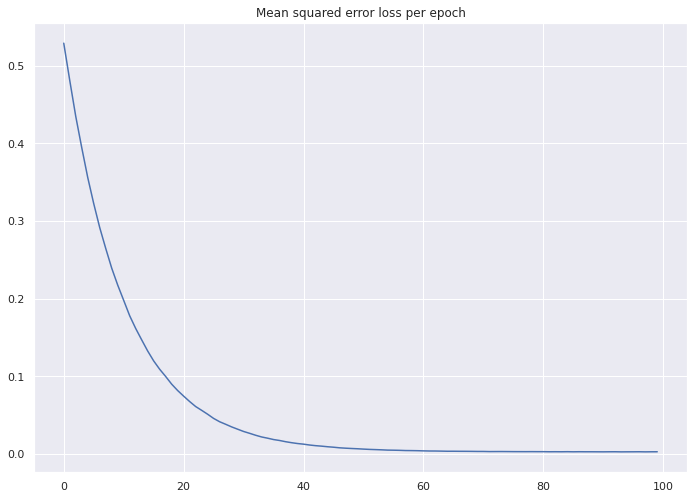

In [9]:
# plot the losses during each epoch
loss_plot = sns.lineplot(x=np.arange(n_epochs), 
                         y=epoch_losses).set_title("Mean squared error loss per epoch")